# NZ Seek Data Analysis

## Data preprocessing

import libs

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

Constant values

In [2]:
DICT_AREA_INDEX = {'Admin':3, 'Banking':3, 'Education':3, 'Manufacture':3}
DICT_DATE_INDEX = {'Admin':4, 'Banking':5,'Education':5, 'Manufacture':5}
DICT_CLASSFICATION_INDEX = {'Admin':5, 'Banking':6,'Education':6, 'Manufacture':6}
DICT_SALARY_FLOOR = {'Admin':35000, 'Banking':53000, 'Education':48000, 'Manufacture':24600}
DICT_SALARY_CEILING = {'Admin':55000, 'Banking':85000,'Education':79000, 'Manufacture':116000}

DICT_DUPLICATE_INDEX = {'Banking':4, 'Education':4, 'Manufacture':4}

LIST_DUPLICATE = ['Banking','Education','Manufacture']

LOCATION_INDEX = 9
CLASSIFICATION_INDEX = 15

HOUR_SALARY_TO_ANNUAL = 8*200

Helping functions

In [3]:
def deduplication(x):
    # deduplication of str
    trim = x.strip()
    index = (trim+trim).find(trim,1)
    if index != -1:
        return trim[:index]

def apply_salary(x):
    if 'classification:' in x:
        return 'unknown'
    else:
        return x

def apply_classification(x):
    if 'classification' in x:
        return x[CLASSIFICATION_INDEX:]
    else:
        return 'unknown'

def apply_posted_time(x):
    if 'd' in x:
        return -int(x[:-1])
    if 'm' in x:
        return -(int(x[:-1])*30)
    else:
        return 0

### Clean Area and Location

In [4]:
def clean_area(df, area_index):

    df[['location', 'area']] = df[area_index].str.split('area:', expand=True)
    df['location'] = df['location'].apply(lambda x: x[LOCATION_INDEX:])
    df['location'] = df['location'].apply(deduplication)

    df['area'].fillna(value='unknown', inplace=True)
    df['area'] = df['area'].apply(deduplication)

    return df

### Clean Classification

In [5]:
def clean_classification(df, classification_index):
    df[['subclassification','classification']]=df[classification_index].str.split('subClassification:', n=1, expand = True)
    df['classification'].fillna('unknown', inplace = True)
    df['classification'] = df['classification'].apply(deduplication)
    df['salary'] = df['subclassification'].apply(apply_salary)
    df['subclassification'] = df['subclassification'].apply(apply_classification)
    df[['classification1', 'classification2', 'classification3']] = df['subclassification'].str.split('&', n=2, expand=True).fillna('unknown')
    return df

### Clean Posted Date

In [6]:
def clean_posted_date(df, posted_date_index):
    df[['posted time', 'featurned at']] = df[posted_date_index].str.split(',', expand=True)[[0, 2]]
    df['featurned at'].fillna('unknown', inplace=True)
    df['posted time'] = df['posted time'].str.extract('(\d+[a-z])')
    df['posted time'].fillna('unknown', inplace = True)
    df['posted time'] = df['posted time'].astype('string')
    df['posted time'] = df['posted time'].apply(apply_posted_time)

    return df

### Clean Salary

In [7]:
def clean_salary(df, salary_floor,salary_ceiling):

    df['salary'] = df[df['salary'].str.contains('\d', na=False)]['salary'].str.replace(' to ', '-', regex=True)
    df['salary'] = df[df['salary'].str.contains('\d', na=False)]['salary'].str.replace('\d\%', '', regex=True)
    df['salary'] = df[df['salary'].str.contains('\d', na=False)]['salary'].str.replace(',', '', regex=True)
    df['salary'] = df[df['salary'].str.contains('\d', na=False)]['salary'].str.replace(' ', '', regex=True)
    df['salary'].fillna('unknown', inplace=True)
    
    df[['low_salary', 'high_salary']] = df['salary'].str.split('-', n=1, expand=True).fillna('unknown')
    df['low_salary'] = df['low_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['high_salary'] = df['high_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['low_salary'] = df[df['low_salary'].str.contains('\d', na=False)]['low_salary'].str.replace('k', '000', regex=True)
    df['high_salary'] = df[df['high_salary'].str.contains('\d', na=False)]['high_salary'].str.replace('k', '000', regex=True)
    df['low_salary'] = df['low_salary'].fillna('unknown')
    df['high_salary'] = df['high_salary'].fillna('unknown')
    df.loc[df['low_salary'] == 'unknown', 'low_salary'] = df['high_salary']
    df.loc[df['high_salary'] == 'unknown', 'high_salary'] = df['low_salary']

    ##set random salary
    for r, row in enumerate(df['low_salary'].values):
        if row == 'unknown':
            df['low_salary'][r] = np.random.randint(salary_floor, salary_ceiling, size=1)[0]

    for r, row in enumerate(df['high_salary'].values):
        if row == 'unknown':
            df['high_salary'][r] = max(np.random.randint(salary_floor, salary_ceiling, size=1)[0], df['low_salary'][r])

    df['low_salary'] = df['low_salary'].astype('float32')
    df['high_salary'] = df['high_salary'].astype('float32')
    df.loc[df['low_salary'] < 50, 'low_salary'] = df['low_salary'] * HOUR_SALARY_TO_ANNUAL
    df.loc[df['high_salary'] < 50, 'high_salary'] = df['high_salary'] * HOUR_SALARY_TO_ANNUAL

    return df

In [8]:
def random_salary(lowest, highest, column_name, is_high, ):
    
     for r, row in enumerate(df[column_name].values):
        if row == 'unknown':
            if is_high == False:
                df[column_name][r] = np.random.randint(salary_floor, salary_ceiling, size=1)[0]
            else:
                df[column_name][r] = max(np.random.randint(salary_floor, salary_ceiling, size=1)[0], df['low_salary'][r])
        

### Clean redundancies

In [9]:
def clean_redundancies(df, job_name):
    df.rename(columns={0: 'Job title', 1: 'website', 2: 'company name'}, inplace=True)
    df['company name'].fillna(df['featurned at'], inplace=True)
    # Drop unuseful columns
    df.drop(DICT_AREA_INDEX[job_name], axis=1, inplace=True)
    df.drop(DICT_DATE_INDEX[job_name], axis=1, inplace=True)
    df.drop(DICT_CLASSFICATION_INDEX[job_name], axis=1, inplace=True)
    df.drop('subclassification', axis=1, inplace=True)
    df.drop('featurned at', axis=1, inplace=True)
    
    if job_name in LIST_DUPLICATE:
        df.drop(DICT_DUPLICATE_INDEX[job_name], axis=1, inplace=True)

    return df
    

### Main clean function

In [10]:
def clean_jobs(path, job_name):

    df = pd.read_excel(path, header=None)

    df = clean_area(df, DICT_AREA_INDEX[job_name])

    df = clean_posted_date(df, DICT_DATE_INDEX[job_name])

    df = clean_classification(df, DICT_CLASSFICATION_INDEX[job_name])

    df = clean_salary(df, DICT_SALARY_FLOOR[job_name], DICT_SALARY_CEILING[job_name])
    
    df = clean_redundancies(df, job_name)

    return df

### Clean Admin jobs

In [11]:
df_admin = clean_jobs("NZ_Admin_JOBS.xlsx", 'Admin')

FileNotFoundError: [Errno 2] No such file or directory: 'NZ_Admin_JOBS.xlsx'

In [11]:
df_admin

,Job title,website,company name,location,area,posted time,classification,salary,classification1,classification2,classification3,low_salary,high_salary
0,Administrator,https://www.seek.co.nz/job/50582301?type=promoted#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Private Advertiser,Bay of Plenty,Tauranga,0,Office Management,unknown,Administration,Office SupportAdministration,Office Support,54589.0,54589.0
1,Receptionist,https://www.seek.co.nz/job/50620889?type=promoted#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Avenues Orthodontics,Bay of Plenty,Tauranga,0,Receptionists,unknown,Administration,Office SupportAdministration,Office Support,51071.0,51071.0
2,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=standard#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,New Zealand Police,Auckland,unknown,-4,Other,unknown,Administration,Office SupportAdministration,Office Support,42195.0,44923.0
3,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=standard#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Kew Pacific Island Early Learning Centre,Southland,Invercargill,0,Administrative Assistants,unknown,Administration,Office SupportAdministration,Office Support,38005.0,44254.0
4,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=standout#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Private Advertiser,Canterbury,Christchurch,-4,Client & Sales Administration,unknown,Administration,Office SupportAdministration,Office Support,44326.0,49781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,Key Account Manager,https://www.seek.co.nz/job/50490062?type=standout#searchRequestToken=c4e3452e-0c7b-47ee-8dcd-97b653d46ce8,Hays Talent Solutions,Auckland,Auckland Central,-27,Client & Sales Administration,unknown,Administration,Office SupportAdministration,Office Support,36167.0,48091.0
2704,Executive Assistant,https://www.seek.co.nz/job/50488000?type=standout#searchRequestToken=c4e3452e-0c7b-47ee-8dcd-97b653d46ce8,one eighty recruitment,Wellington,"Wellington CentralWellington Central,Competitive hourly rate",-27,unknown,unknown,unknown,unknown,unknown,43234.0,48212.0
2705,Temporary Office Roles,https://www.seek.co.nz/job/50524865?type=standout#searchRequestToken=c4e3452e-0c7b-47ee-8dcd-97b653d46ce8,Asset Recruitment Ltd,Waikato,"HamiltonHamilton,Competitive hourly rates $$",-20,unknown,unknown,unknown,unknown,unknown,42300.0,42300.0
2706,Temporary Office Roles,https://www.seek.co.nz/job/50477118?type=standout#searchRequestToken=c4e3452e-0c7b-47ee-8dcd-97b653d46ce8,Asset Recruitment Ltd,Waikato,"HamiltonHamilton,Competitive hourly rates $$",-28,unknown,unknown,unknown,unknown,unknown,54027.0,54027.0


### Clean Banking Jobs

In [12]:
df_banking = clean_jobs("NZ_Banking_JOBS.xlsx", 'Banking')

In [13]:
df_banking

,Job title,website,company name,location,area,posted time,classification,salary,classification1,classification2,classification3,low_salary,high_salary
0,Accounts Receivable,https://www.seek.co.nz/job/50568753?type=promoted#searchRequestToken=d0513dee-bb65-4c2d-ae6a-7f4b8838529d,at MTF Finance Mt Wellington,Auckland,Auckland Central,0,Credit,unknown,Banking,Financial ServicesBanking,Financial Services,84030.0,84685.0
1,Internal Audit Manager,https://www.seek.co.nz/job/50556333?type=promoted#searchRequestToken=d0513dee-bb65-4c2d-ae6a-7f4b8838529d,at Industrial and Commercial Bank of China (New Zealand) Ltd,Auckland,Auckland Central,0,Compliance & Risk,unknown,Banking,Financial ServicesBanking,Financial Services,67507.0,67507.0
2,Client Services Officer,https://www.seek.co.nz/job/50638706?type=standard#searchRequestToken=d0513dee-bb65-4c2d-ae6a-7f4b8838529d,at NZ Funds Management Limited,Auckland,Auckland Central,0,Client Services,unknown,Banking,Financial ServicesBanking,Financial Services,73499.0,73499.0
3,Customer Banking Consultant - Invercargill,https://www.seek.co.nz/job/50637958?type=standout#searchRequestToken=d0513dee-bb65-4c2d-ae6a-7f4b8838529d,at Westpac,Southland,"InvercargillInvercargill,Salary + benefits + career progression",-1,unknown,unknown,unknown,unknown,unknown,66579.0,75173.0
4,Private Wealth Assistant - Queenstown,https://www.seek.co.nz/job/50617226?type=standout#searchRequestToken=d0513dee-bb65-4c2d-ae6a-7f4b8838529d,at Craigs Investment Partners,Otago,Queenstown & Wanaka,-5,Client Services,unknown,Banking,Financial ServicesBanking,Financial Services,82060.0,82060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3879,Financial Advisor,https://www.seek.co.nz/job/50497173?type=standard#searchRequestToken=b74a7d56-737d-4f6e-9e4d-375bdd69aeb9,at NetYourJob,Auckland,"Rodney & North ShoreRodney & North Shore,Flexible Hours - Remuneration Negotiable",-26,unknown,unknown,unknown,unknown,unknown,65865.0,65865.0
3880,Senior Private Wealth Specialist,https://www.seek.co.nz/job/50526368?type=standout#searchRequestToken=b74a7d56-737d-4f6e-9e4d-375bdd69aeb9,at Debbie Graham & Associates Limited,Auckland,unknown,-20,Financial Planning,unknown,Banking,Financial ServicesBanking,Financial Services,75373.0,82326.0
3881,Financial Adviser (Auckland),https://www.seek.co.nz/job/50501103?type=standard#searchRequestToken=b74a7d56-737d-4f6e-9e4d-375bdd69aeb9,at Tyler Wren,Auckland,"Auckland CentralAuckland Central,Market Related base salary + Company benefits",-25,unknown,unknown,unknown,unknown,unknown,72570.0,72570.0
3882,New Ventures Manager,https://www.seek.co.nz/job/50487878?type=standard#searchRequestToken=b74a7d56-737d-4f6e-9e4d-375bdd69aeb9,at Matthew Wood Search,Auckland,Auckland Central,-27,Corporate Finance & Investment Banking,unknown,Banking,Financial ServicesBanking,Financial Services,58270.0,58270.0


### Education Jobs

In [14]:
df_education = clean_jobs("NZ_EDUCATION_TRAINING_JOBS.xlsx", 'Education')

In [15]:
df_education

,Job title,website,company name,location,area,posted time,classification,salary,classification1,classification2,classification3,low_salary,high_salary
0,Registered Teacher - Early Learning,https://www.seek.co.nz/job/50638844?type=promoted#searchRequestToken=fb90bb9e-7e40-4113-af51-a9f7d25bf152,at Central Hastings Preschool,Hawkes Bay,Hastings,0,Teaching - Early Childhood,unknown,Education,TrainingEducation,Training,72326.0,72326.0
1,Education Management Expert,https://www.seek.co.nz/job/50615703?type=promoted#searchRequestToken=fb90bb9e-7e40-4113-af51-a9f7d25bf152,at EIT,Hawkes Bay,Napier,0,Management - Universities,unknown,Education,TrainingEducation,Training,51462.0,63472.0
2,Principal Support Officer,https://www.seek.co.nz/job/50638750?type=standout#searchRequestToken=fb90bb9e-7e40-4113-af51-a9f7d25bf152,at NZEI,Waikato,"HamiltonHamilton,$76,696 - $93,676",-1,unknown,$76696-$93676,unknown,unknown,unknown,76696.0,93676.0
3,Learning Assistant,https://www.seek.co.nz/job/50633316?type=standout#searchRequestToken=fb90bb9e-7e40-4113-af51-a9f7d25bf152,at St Peter's School,Waikato,Rest of Waikato,-4,Teaching Aides & Special Needs,unknown,Education,TrainingEducation,Training,68474.0,68474.0
4,English Language Partners Centre Manager - Waikato,https://www.seek.co.nz/job/50646175?type=standout#searchRequestToken=fb90bb9e-7e40-4113-af51-a9f7d25bf152,at English Language Partners NZ,Waikato,Hamilton,0,Management - Schools,unknown,Education,TrainingEducation,Training,54392.0,76874.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,Research Fellow in Physiology - Faculty of Medical & Health Science,https://www.seek.co.nz/job/50584769?type=standout#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at The University of Auckland,Auckland,Auckland Central,-12,Research & Fellowships,unknown,Education,TrainingEducation,Training,62531.0,62925.0
4401,Early Childhood Teacher - Central Auckland,https://www.seek.co.nz/job/50493625?type=standard#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at Randstad - Education,"AucklandAuckland,$25 - $29 p.h.",unknown,-27,unknown,$25-$29p.h.,unknown,unknown,unknown,40000.0,46400.0
4402,Postdoctoral Fellow,https://www.seek.co.nz/job/50575193?type=standout#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at Massey University,Manawatu,Palmerston North,-13,Research & Fellowships,unknown,Education,TrainingEducation,Training,78811.0,78811.0
4403,Early Childhood Teacher - Albany,https://www.seek.co.nz/job/50493623?type=standard#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at Randstad - Education,Auckland,"Rodney & North ShoreRodney & North Shore,$25 - $30 p.h.",-27,unknown,$25-$30p.h.,unknown,unknown,unknown,40000.0,48000.0


### Clean Manufacture

In [16]:
df_manufacture = clean_jobs("NZ_Manufacture_JOBS.xlsx", 'Manufacture')

In [17]:
df_manufacture

,Job title,website,company name,location,area,posted time,classification,salary,classification1,classification2,classification3,low_salary,high_salary
0,"Logistics, Warehousing & Service Support",https://www.seek.co.nz/job/50646703?type=promoted#searchRequestToken=166d94f9-d4a1-47bd-8384-260d2bdad22f,Aquatec Fluid Systems,Canterbury,Christchurch,0,"Warehousing, Storage & Distribution",unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,93221.0,93221.0
1,Ferry Deckhand,https://www.seek.co.nz/job/50508406?type=promoted#searchRequestToken=166d94f9-d4a1-47bd-8384-260d2bdad22f,SeaLink Travel Group,Auckland,Manukau & East Auckland,0,Rail & Maritime Transport,unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,69667.0,69667.0
2,Store Person,https://www.seek.co.nz/job/50638896?type=standout#searchRequestToken=166d94f9-d4a1-47bd-8384-260d2bdad22f,Halls,Auckland,Auckland Central,-1,"Warehousing, Storage & Distribution",unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,48264.0,104680.0
3,Warehouse Operator,https://www.seek.co.nz/job/50646678?type=standout#searchRequestToken=166d94f9-d4a1-47bd-8384-260d2bdad22f,TriCab (Australia) Pty Ltd,Canterbury,Christchurch,-1290,"Warehousing, Storage & Distribution",unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,112211.0,112211.0
4,Full Time - Warehouse Operator,https://www.seek.co.nz/job/50639558?type=standard#searchRequestToken=166d94f9-d4a1-47bd-8384-260d2bdad22f,AS Colour,Auckland,Waitakere & West Auckland,-1,"Warehousing, Storage & Distribution",unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,63855.0,103807.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5889,Civil Class 4/5 Drivers,https://www.seek.co.nz/job/50493651?type=standout#searchRequestToken=c0860186-d8aa-46be-b348-44c39e39920b,Tech 5 Recruitment Ltd,Canterbury,"ChristchurchChristchurch,$24.00-$26.00/hr depending on experience",-27,unknown,$24.00-$26.00/hrdependingonexperience,unknown,unknown,unknown,38400.0,41600.0
5890,STMS and Traffic Controllers Required,https://www.seek.co.nz/job/50485304?type=standard#searchRequestToken=c0860186-d8aa-46be-b348-44c39e39920b,Tradestaff,Waikato,"HamiltonHamilton,NZD22 - NZD30 per hour",-28,unknown,NZD22-NZD30perhour,unknown,unknown,unknown,35200.0,48000.0
5891,HIAB Driver,https://www.seek.co.nz/job/50493630?type=standout#searchRequestToken=c0860186-d8aa-46be-b348-44c39e39920b,AWF,Auckland,Rodney & North Shore,-27,Road Transport,unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,46496.0,81679.0
5892,Class 5 Driver Night shift,https://www.seek.co.nz/job/50487730?type=standard#searchRequestToken=c0860186-d8aa-46be-b348-44c39e39920b,Superior Personnel Ltd,Bay of Plenty,Tauranga,-28,Road Transport,unknown,"Manufacturing, Transport","LogisticsManufacturing, Transport",Logistics,40549.0,115283.0


In [19]:
df_admin['Domain'] = 'Admin'
df_banking['Domain'] = 'Banking'
df_manufacture['Domain'] = 'Manufacture'
df_education['Domain'] = 'Education'

In [20]:
result_df = pd.concat([df_admin, df_banking, df_manufacture,df_education], ignore_index=True, sort=False)

In [21]:
result_df.loc[result_df['location'].str.contains('Auckland'), 'location'] = 'Auckland'
result_df.loc[result_df['location'].str.contains('Wellington'), 'location'] = 'Wellington'

In [22]:
result_df

,Job title,website,company name,location,area,posted time,classification,salary,classification1,classification2,classification3,low_salary,high_salary,Domain
0,Administrator,https://www.seek.co.nz/job/50582301?type=promoted#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Private Advertiser,Bay of Plenty,Tauranga,0,Office Management,unknown,Administration,Office SupportAdministration,Office Support,54589.0,54589.0,Admin
1,Receptionist,https://www.seek.co.nz/job/50620889?type=promoted#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Avenues Orthodontics,Bay of Plenty,Tauranga,0,Receptionists,unknown,Administration,Office SupportAdministration,Office Support,51071.0,51071.0,Admin
2,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=standard#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,New Zealand Police,Auckland,unknown,-4,Other,unknown,Administration,Office SupportAdministration,Office Support,42195.0,44923.0,Admin
3,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=standard#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Kew Pacific Island Early Learning Centre,Southland,Invercargill,0,Administrative Assistants,unknown,Administration,Office SupportAdministration,Office Support,38005.0,44254.0,Admin
4,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=standout#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Private Advertiser,Canterbury,Christchurch,-4,Client & Sales Administration,unknown,Administration,Office SupportAdministration,Office Support,44326.0,49781.0,Admin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16886,Research Fellow in Physiology - Faculty of Medical & Health Science,https://www.seek.co.nz/job/50584769?type=standout#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at The University of Auckland,Auckland,Auckland Central,-12,Research & Fellowships,unknown,Education,TrainingEducation,Training,62531.0,62925.0,Education
16887,Early Childhood Teacher - Central Auckland,https://www.seek.co.nz/job/50493625?type=standard#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at Randstad - Education,Auckland,unknown,-27,unknown,$25-$29p.h.,unknown,unknown,unknown,40000.0,46400.0,Education
16888,Postdoctoral Fellow,https://www.seek.co.nz/job/50575193?type=standout#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at Massey University,Manawatu,Palmerston North,-13,Research & Fellowships,unknown,Education,TrainingEducation,Training,78811.0,78811.0,Education
16889,Early Childhood Teacher - Albany,https://www.seek.co.nz/job/50493623?type=standard#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,at Randstad - Education,Auckland,"Rodney & North ShoreRodney & North Shore,$25 - $30 p.h.",-27,unknown,$25-$30p.h.,unknown,unknown,unknown,40000.0,48000.0,Education


In [23]:
result_df['company name'] = result_df['company name'].str.replace('at ', '', regex=True)

In [24]:
result_df

,Job title,website,company name,location,area,posted time,classification,salary,classification1,classification2,classification3,low_salary,high_salary,Domain
0,Administrator,https://www.seek.co.nz/job/50582301?type=promoted#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Private Advertiser,Bay of Plenty,Tauranga,0,Office Management,unknown,Administration,Office SupportAdministration,Office Support,54589.0,54589.0,Admin
1,Receptionist,https://www.seek.co.nz/job/50620889?type=promoted#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Avenues Orthodontics,Bay of Plenty,Tauranga,0,Receptionists,unknown,Administration,Office SupportAdministration,Office Support,51071.0,51071.0,Admin
2,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=standard#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,New Zealand Police,Auckland,unknown,-4,Other,unknown,Administration,Office SupportAdministration,Office Support,42195.0,44923.0,Admin
3,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=standard#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Kew Pacific Island Early Learning Centre,Southland,Invercargill,0,Administrative Assistants,unknown,Administration,Office SupportAdministration,Office Support,38005.0,44254.0,Admin
4,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=standout#searchRequestToken=feee129e-c80f-4f79-ac5f-98ddb6d6c22b,Private Advertiser,Canterbury,Christchurch,-4,Client & Sales Administration,unknown,Administration,Office SupportAdministration,Office Support,44326.0,49781.0,Admin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16886,Research Fellow in Physiology - Faculty of Medical & Health Science,https://www.seek.co.nz/job/50584769?type=standout#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,The University of Auckland,Auckland,Auckland Central,-12,Research & Fellowships,unknown,Education,TrainingEducation,Training,62531.0,62925.0,Education
16887,Early Childhood Teacher - Central Auckland,https://www.seek.co.nz/job/50493625?type=standard#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,Randstad - Education,Auckland,unknown,-27,unknown,$25-$29p.h.,unknown,unknown,unknown,40000.0,46400.0,Education
16888,Postdoctoral Fellow,https://www.seek.co.nz/job/50575193?type=standout#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,Massey University,Manawatu,Palmerston North,-13,Research & Fellowships,unknown,Education,TrainingEducation,Training,78811.0,78811.0,Education
16889,Early Childhood Teacher - Albany,https://www.seek.co.nz/job/50493623?type=standard#searchRequestToken=226ff771-6119-4bf6-8cdf-d71a29ca718f,Randstad - Education,Auckland,"Rodney & North ShoreRodney & North Shore,$25 - $30 p.h.",-27,unknown,$25-$30p.h.,unknown,unknown,unknown,40000.0,48000.0,Education


In [25]:
x_df = result_df[['Job title', 'company name', 'location','posted time']]
#x_df = result_df[['location','Domain']]
y_df = result_df['high_salary']

In [98]:
x_df

,Job title,company name,location,posted time
0,Administrator,Private Advertiser,Bay of Plenty,0
1,Receptionist,Avenues Orthodontics,Bay of Plenty,0
2,Prosecutions Support Officer,New Zealand Police,Auckland,-4
3,Early Childhood Centre Administrator,Kew Pacific Island Early Learning Centre,Southland,0
4,Business Support Administrator,Private Advertiser,Canterbury,-4
...,...,...,...,...
16886,Research Fellow in Physiology - Faculty of Medical & Health Science,The University of Auckland,Auckland,-12
16887,Early Childhood Teacher - Central Auckland,Randstad - Education,Auckland,-27
16888,Postdoctoral Fellow,Massey University,Manawatu,-13
16889,Early Childhood Teacher - Albany,Randstad - Education,Auckland,-27


### Encoding qualitative data

In [99]:
from sklearn.preprocessing import LabelEncoder

x_df = x_df.apply(LabelEncoder().fit_transform)
#x_df[['Job title','company name','location','Domain']] = x_df[['Job title','company name','location','Domain']].apply(LabelEncoder().fit_transform)

In [100]:
x_df

,Job title,company name,location,posted time
0,58,901,1,52
1,1751,110,1,52
2,1665,786,0,48
3,622,592,12,52
4,195,901,2,48
...,...,...,...,...
16886,1808,1178,0,40
16887,629,936,0,25
16888,1525,688,7,39
16889,627,936,0,25


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=0)

In [79]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, x_df, y_df, cv=5, scoring='r2')
    return pred

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [48]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [49]:
print(lin_reg.intercept_)

78071.87527190997


In [50]:
coeff_df = pd.DataFrame(lin_reg.coef_, x_df.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Job title,-0.881172
company name,-8.654047
location,-404.795094
posted time,1.444970


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [52]:
pred = lin_reg.predict(X_test)

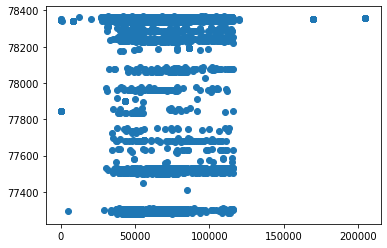

In [53]:
plt.scatter(y_test, pred)

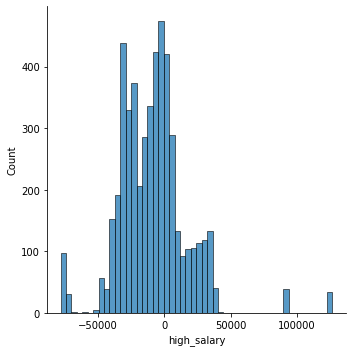

In [54]:
sns.displot((y_test - pred), bins=50);

In [83]:
evaluate_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
evaluate_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,10198.320434,2.347753e+08,15322.38067,0.662282,"[-1.2804846205000566, -0.24174734346621984, -0.16537364320166037, -0.009263495454942872, -0.3344197376714184]"


In [55]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 20395.978320807008
MSE: 769380307.5730737
RMSE: 27737.705521060565
R2 Square -0.10673418664398437
Train set evaluation:
_____________________________________
MAE: 19764.438497244744
MSE: 729146371.1327324
RMSE: 27002.710440486015
R2 Square -0.10721287336368657


In [57]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=5)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 25829.552105232233
MSE: 207163796023.07773
RMSE: 455152.49754678673
R2 Square -296.99990074727157
Train set evaluation:
_____________________________________
MAE: 12465.664676319602
MSE: 328801743.786262
RMSE: 18132.891214206906
R2 Square 0.5007126992362055


In [94]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 9289.539260726853
MSE: 198209230.6098977
RMSE: 14078.680002397161
R2 Square 0.6982663130412536
Train set evaluation:
_____________________________________
MAE: 7295.936480182178
MSE: 123696844.2839091
RMSE: 11121.908302261312
R2 Square 0.8167321140596029


In [95]:
evaluate_df_random_forest = pd.DataFrame(data=[["Random Forest Regression", *evaluate(y_test, test_pred) , cross_val(RandomForestRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
evaluate_df_random_forest

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Random Forest Regression,9289.539261,1.982092e+08,14078.680002,0.698266,"[-1.609900149535838, 0.8809280396914085, -0.02658976736950791, 0.5135161860330784, 0.8849599854288627]"


In [69]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### Gradient boost

In [118]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=13)

In [121]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 1000,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'huber'}

gb_reg = GradientBoostingRegressor(**params)
gb_reg.fit(X_train, y_train)

test_pred = gb_reg.predict(X_test)
train_pred = gb_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 10137.049010340412
MSE: 222598032.976148
RMSE: 14919.719601123474
R2 Square 0.6616795089603633
Train set evaluation:
_____________________________________
MAE: 9009.307864569553
MSE: 170980973.65983477
RMSE: 13075.96932008617
R2 Square 0.7464996881887009


In [122]:
evaluate_df_gb = pd.DataFrame(data=[["GradientBoostingRegressor", *evaluate(y_test, test_pred) , cross_val(GradientBoostingRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
evaluate_df_gb

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,GradientBoostingRegressor,10137.04901,2.225980e+08,14919.719601,0.66168,"[-1.4809024568961355, 0.27665347359705605, 0.02288286825747754, 0.36349031613473204, 0.3570143529905955]"


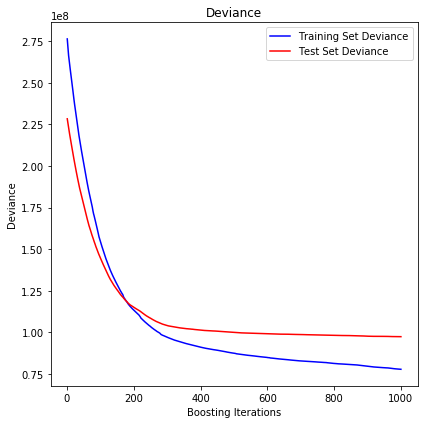

In [123]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gb_reg.staged_predict(X_test)):
    test_score[i] = gb_reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gb_reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

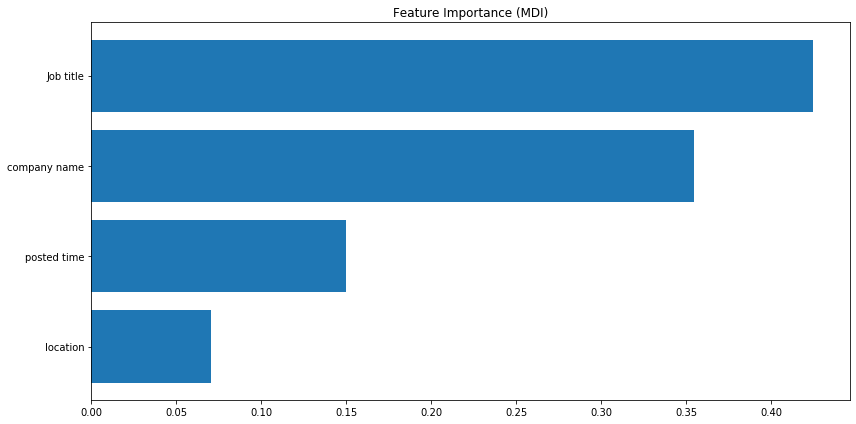

In [129]:
feature_importance = gb_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
fig.tight_layout()
plt.show()

### classification

### check if a job is an Admin job

In [26]:
x_df = result_df[['company name', 'location','posted time', 'low_salary','high_salary']]
y_df = np.where(result_df['Domain']=='Admin', 1, 0)

In [27]:
x_df

,company name,location,posted time,low_salary,high_salary
0,Private Advertiser,Bay of Plenty,0,45447.0,45447.0
1,Avenues Orthodontics,Bay of Plenty,0,39036.0,43836.0
2,New Zealand Police,Auckland,-4,38651.0,48119.0
3,Kew Pacific Island Early Learning Centre,Southland,0,41487.0,41487.0
4,Private Advertiser,Canterbury,-4,52290.0,52290.0
...,...,...,...,...,...
16886,The University of Auckland,Auckland,-12,73091.0,73091.0
16887,Randstad - Education,Auckland,-27,40000.0,46400.0
16888,Massey University,Manawatu,-13,57600.0,57600.0
16889,Randstad - Education,Auckland,-27,40000.0,48000.0


In [28]:
np.count_nonzero(y_df == 1)

2708

In [29]:
from sklearn.preprocessing import LabelEncoder

x_df = x_df.apply(LabelEncoder().fit_transform)

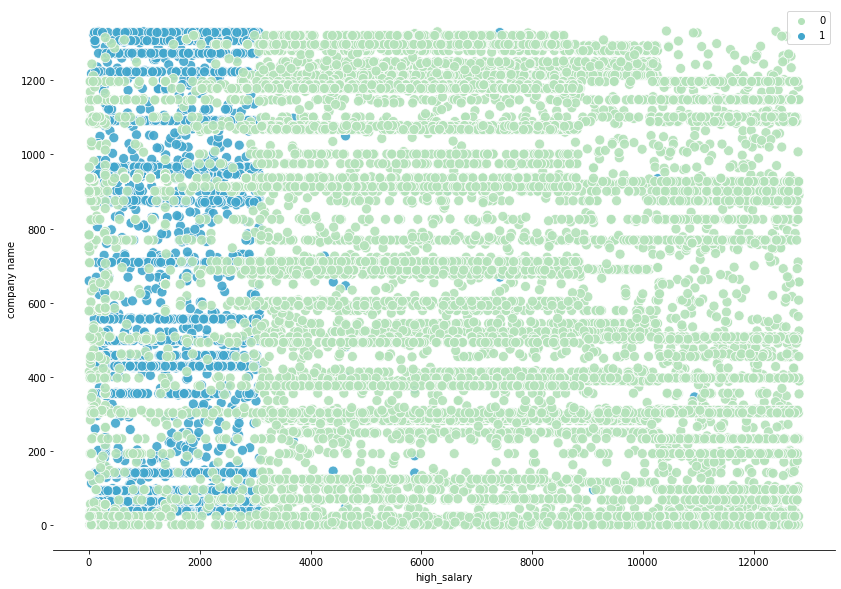

In [30]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='high_salary', y='company name', data=x_df, hue=y_df, palette='GnBu', s=100, alpha=0.9)
sns.despine(left=True)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=1)

In [32]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

def print_evaluate(classifier, y_test, prediction):  
    scores_accuracy = cross_val_score(classifier, x_df, y_df, cv=10, scoring='accuracy')
    scores_f1 = cross_val_score(classifier, x_df, y_df, cv=10, scoring='f1_macro')
    print('K-fold cross-validation results:')
    print(classifier.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
    print(classifier.__class__.__name__+" average f1 is %2.3f" % scores_f1.mean())
    print('Classification report: ')
    print(classification_report(y_test, prediction))


### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

prediction = logreg.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction)

array([[2724,  128],
       [ 285,  242]])

In [35]:
print_evaluate(logreg, y_test, prediction)

K-fold cross-validation results:
LogisticRegression average accuracy is 0.873
LogisticRegression average f1 is 0.725
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2852
           1       0.65      0.46      0.54       527

    accuracy                           0.88      3379
   macro avg       0.78      0.71      0.73      3379
weighted avg       0.87      0.88      0.87      3379



In [36]:
from sklearn.metrics import roc_curve, auc
def plot_auc(y_test, prediction):
    [fpr, tpr, thr] = roc_curve(y_test, prediction)
    idx = np.min(np.where(tpr > 0.8))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

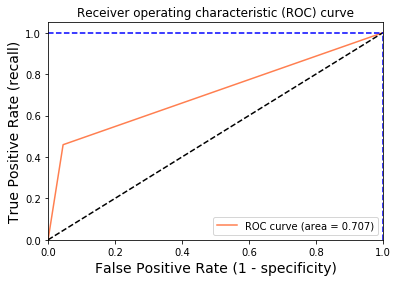

In [37]:
plot_auc(y_test, prediction)

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [39]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

prediction = logreg.predict(X_test)

In [40]:
print_evaluate(logreg, y_test, prediction)

K-fold cross-validation results:
LogisticRegression average accuracy is 0.873
LogisticRegression average f1 is 0.725
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2852
           1       0.66      0.46      0.54       527

    accuracy                           0.88      3379
   macro avg       0.78      0.71      0.74      3379
weighted avg       0.87      0.88      0.87      3379



### Decision tree 

In [41]:
y_df = result_df['Domain']

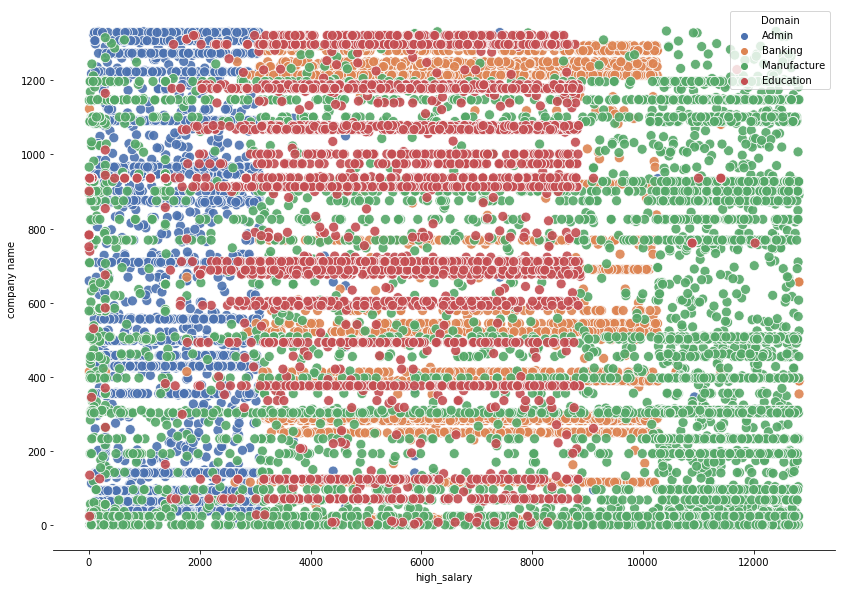

In [42]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='high_salary', y='company name', data=x_df, hue=y_df, palette='deep', s=100, alpha=0.9)
sns.despine(left=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=15)

In [44]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)

prediction = dtc.predict(X_test)

In [45]:
print_evaluate(dtc, y_test, prediction)

K-fold cross-validation results:
DecisionTreeClassifier average accuracy is 0.926
DecisionTreeClassifier average f1 is 0.920
Classification report: 
              precision    recall  f1-score   support

       Admin       0.91      0.90      0.91       536
     Banking       0.96      0.97      0.96       772
   Education       0.95      0.93      0.94       874
 Manufacture       0.92      0.93      0.93      1197

    accuracy                           0.93      3379
   macro avg       0.93      0.93      0.93      3379
weighted avg       0.93      0.93      0.93      3379



In [52]:
importance = dtc.feature_importances_
importance

array([0.35267088, 0.02486529, 0.15541466, 0.09794714, 0.36910203])

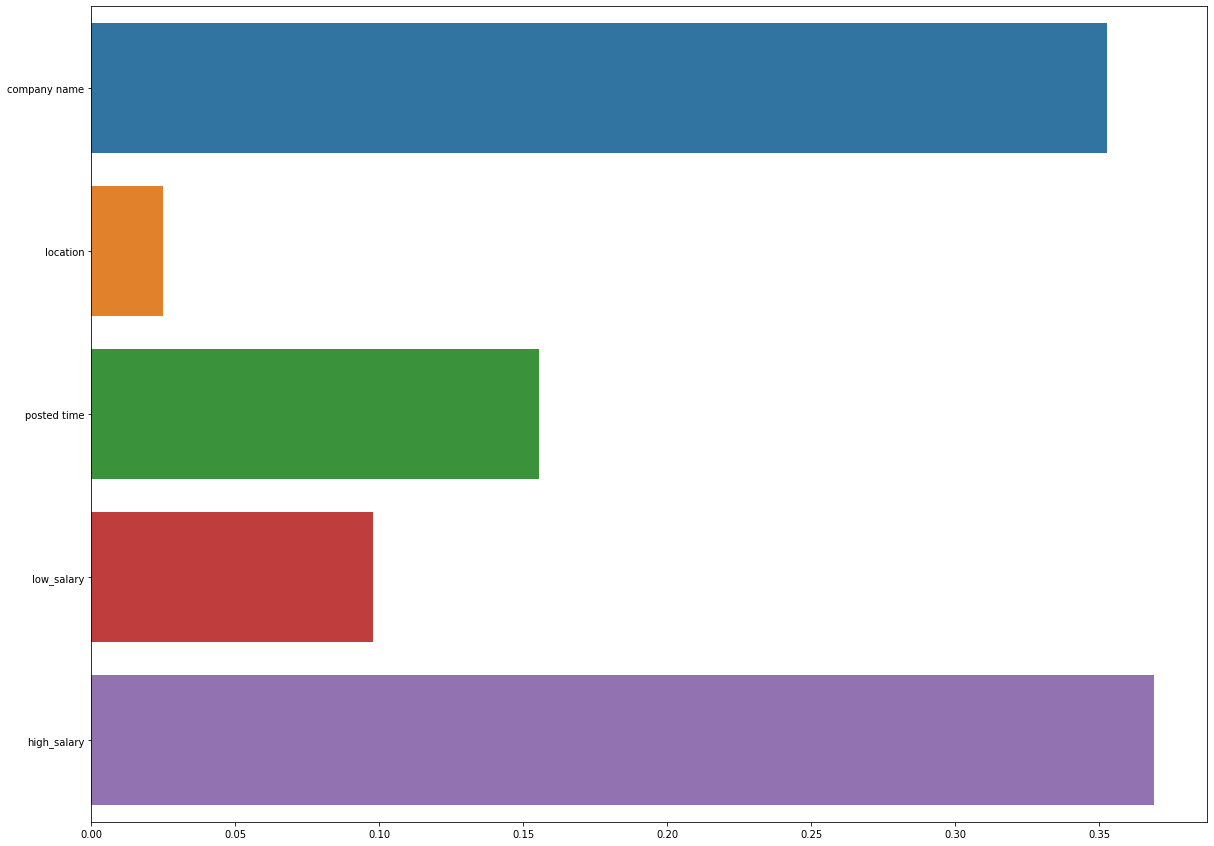

In [53]:
sns.barplot(x=importance, y=x_df.columns)

[Text(784.8977359340355, 798.4125, 'X[4] <= 10342.5\nentropy = 0.732\nsamples = 13512\nvalue = [2172, 3112, 3531, 4697]'),
 Text(463.2975561252772, 764.4375, 'X[4] <= 3074.5\nentropy = 0.742\nsamples = 11250\nvalue = [2172, 2923, 3525, 2630]'),
 Text(150.27664564855877, 730.4625, 'X[3] <= 557.0\nentropy = 0.617\nsamples = 4169\nvalue = [2147, 13, 890, 1119]'),
 Text(34.22235033259424, 696.4875, 'X[4] <= 15.5\nentropy = 0.512\nsamples = 820\nvalue = [45, 2, 270, 503]'),
 Text(6.3347228381374725, 662.5124999999999, 'X[2] <= 38.0\nentropy = 0.352\nsamples = 334\nvalue = [1, 2, 259, 72]'),
 Text(3.1673614190687363, 628.5374999999999, 'X[0] <= 745.5\nentropy = 0.015\nsamples = 257\nvalue = [0, 0, 255, 2]'),
 Text(1.5836807095343681, 594.5625, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1]'),
 Text(4.751042128603104, 594.5625, 'X[3] <= 4.5\nentropy = 0.008\nsamples = 256\nvalue = [0, 0, 255, 1]'),
 Text(3.1673614190687363, 560.5875, 'entropy = 0.0\nsamples = 172\nvalue = [0, 0, 172, 0]'),

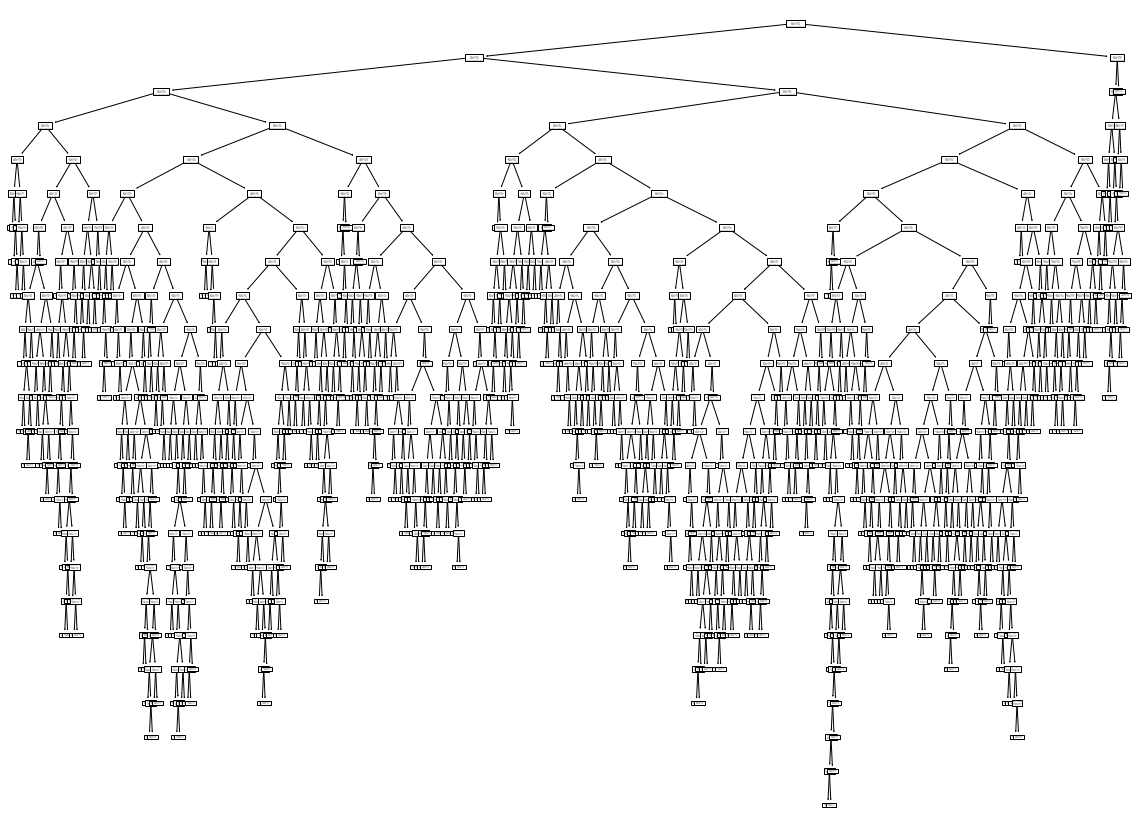

In [51]:
from sklearn import tree
plt.rcParams['figure.figsize'] = [20, 15]
tree.plot_tree(dtc) 